In [257]:
import numpy as np
import pandas as pd
import warnings

from tqdm import tqdm
import re

import pickle
import progiter
from collections import defaultdict

In [258]:
with open('title_lists.dump', 'rb') as f:
    title_lists = pickle.load(f)

In [259]:
with open('text_lists.dump', 'rb') as f:
    text_lists = pickle.load(f)

In [260]:
# create words hash - entropy
words = defaultdict(int)
for text_list in progiter.ProgIter( text_lists ):
    for word in text_list:
        words[word] += 1
        
# find max
max_count = 0
for word in progiter.ProgIter( words.keys() ):
    a = words[word]
    if a > max_count:
        max_count = a

for word in progiter.ProgIter( words.keys() ):
    words[word] = 1 - (words[word]/max_count)

 738244/738244... rate=26550.87 Hz, eta=0:00:00, total=0:00:27, wall=19:03 RTZ 2 (çèìà)
 787228/787228... rate=1656426.03 Hz, eta=0:00:00, total=0:00:00, wall=19:03 RTZ 2 (çèìà)
 787228/787228... rate=1454945.63 Hz, eta=0:00:00, total=0:00:00, wall=19:03 RTZ 2 (çèìà)


In [261]:
# calculate average entropy
text_entropy = []
for text_list in progiter.ProgIter( text_lists ):
    len_text_list = len( text_list )
    if len_text_list == 0:
        text_entropy.append(0)
        continue
    entropy = 0
    for word in text_list:
        entropy += words[word]
    text_entropy.append( entropy / len_text_list )
    

 738244/738244... rate=35246.32 Hz, eta=0:00:00, total=0:00:20, wall=19:04 RTZ 2 (çèìà)


In [262]:
text_entropy[0:20]

[0.8789796782883652,
 0.9516833652178787,
 0.9289548951994725,
 0.90823925991618,
 0.9493058367780232,
 0.9671553290975818,
 0.9419921237854934,
 0.9651463708816084,
 0.9588501473909496,
 0.9386280544192354,
 0.9149164814588603,
 0.9494906449540105,
 0.9575824360440508,
 0.9341557273775937,
 0.9317840938518345,
 0.9448299356030851,
 0.9828320308987386,
 0.9403526167666125,
 0.9554290497688056,
 0.9628163668717314]

In [263]:
max_total_words = 0
for text_list in text_lists:
    l = len(text_list)
    if l > max_total_words:
        max_total_words = l
        
max_total_words

5005

In [264]:
# doc entropy, normalized amount of words with wntropy
# <= 0.5, 0.5 < x < 0.8, 0,8 <= x <= 1
features = []
for text_list in progiter.ProgIter( text_lists ):
    total_words = len(text_list)
    if total_words == 0:
        features.append( [0, 0, 0, 0] )
        continue
        
    a1 = 0 # doc average entropy
    a2 = 0 #
    a3 = 0 #
    a4 = 0 #
    a5 = total_words / max_total_words # how many words in (normalized)
    
    for word in text_list:
        a1 += words[word]
    a1 = a1 / total_words
    
    for word in text_list:
        ent = words[word]
        if (ent <= 0.5):
            a2 += 1
        elif (ent > 0.5) and (ent < 0.8):
            a3 += 1
        elif (ent >= 0.8):
            a4 += 1
            
    a2 = a2 / total_words
    a3 = a3 / total_words
    a4 = a4 / total_words
    features.append( [a1, a2, a3, a4, a5] )

 738244/738244... rate=15966.03 Hz, eta=0:00:00, total=0:00:56, wall=19:05 RTZ 2 (çèìà)


In [265]:
features[0:2]

[[0.8789796782883652, 0.0625, 0.109375, 0.828125, 0.012787212787212787],
 [0.9516833652178787,
  0.010309278350515464,
  0.05154639175257732,
  0.9381443298969072,
  0.01938061938061938]]

In [266]:
count = 10
strings_list = [' '.join(tokens) for tokens in title_lists]
for i in range(len(strings_list)):
    print (i, strings_list[i] )
    count -= 1
    if count == 0: 
        break
    

0 Названы регионы России с самой высокой смертностью от рака
1 Австрия не представила доказательств вины российских биатлонистов
2 Обнаружено самое счастливое место на планете
3 В США раскрыли сумму расходов на расследование «российского дела»
4 Хакеры рассказали о планах Великобритании заминировать Севастополь
5 Архиепископ канонической УПЦ отказался прийти на «сатанинское сборище» в Киеве
6 Российскую молодежь предложили обучать духовным ценностям в соцсетях
7 Полицейские из Солсбери описали одеревеневшего Скрипаля
8 Полет российских бомбардировщиков над Карибским морем сняли на видео
9 В Минобороны раскрыли многомиллионные хищения при ремонте зениток


In [267]:
# разметка данных
news_class = []
fnews = "0 2 12 13 20 27 40 41 44 51 53 57 58 59 60 61 63 66 68 69 70 74 76 77 80 81 82 85 90 93 94 95 96 98 \
         101 102 103 105 110 113 114 122 124 125 128 132 135 140 142 146 156 157 158 159 163 165 169 171 173 \
         174 178 184 191 202 204 207 208 210 214 216 218 220 221 224 229 234 238 240 241 242 243 244 248 250 \
         252 253 254 257 258 259 262 263 265 267 270 275 276 278 279 282 286 287 288 289 294 295 297 299 304 \
         305 308 311 312 313 315 321 322 323 325 328 329 333 334 336 339 340 341 345 351 352 358 360 364 369 \
         371 374 376 379 382 387 388 391 392 395 398"
fnews_list = re.split(r' +', fnews);
for i in range(len(fnews_list)):
    fnews_list[i] = int(fnews_list[i])
for i in range(400):
    if i in fnews_list:
        news_class.append(1)
    else:
        news_class.append(0)

In [268]:
# посмотрим на проекции 5-мерного пространства
# попробуем визуально определить насколько кластеризуема выборка
import matplotlib.pyplot as plt
%matplotlib inline

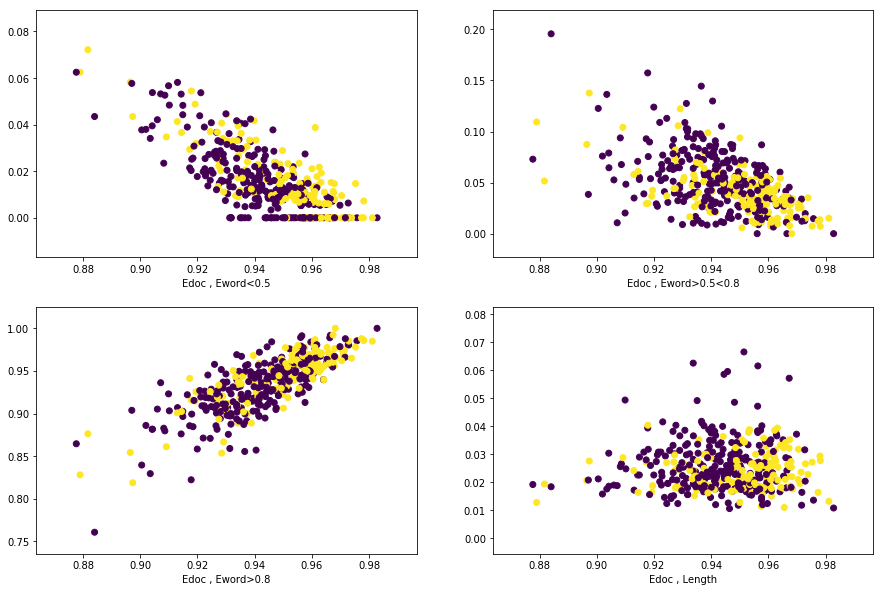

In [269]:
labels = ['Edoc','Eword<0.5','Eword>0.5<0.8','Eword>0.8','Length']
x = [features[j][0] for j in range(400)]
plt.figure(figsize=(15,10))

for i in range(1,5):
    y = [features[j][i] for j in range(400)]
    plt.subplot(2,2,i)
    plt.scatter(x, y, c=news_class)
    plt.xlabel(f'{labels[0]} , {labels[i]}')

plt.show()

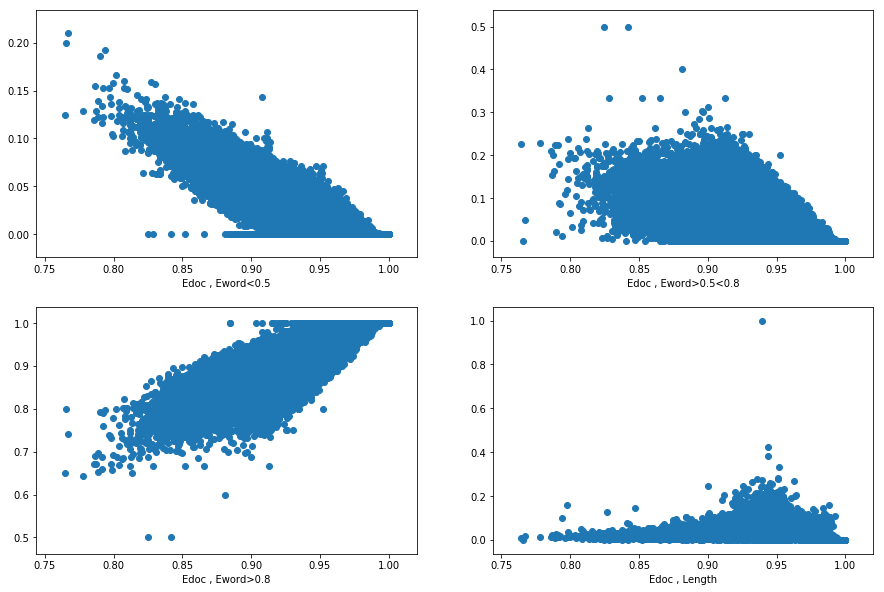

In [270]:
# визуализируем все значения параметров
labels = ['Edoc','Eword<0.5','Eword>0.5<0.8','Eword>0.8','Length']
x = [features[j][0] for j in range(len(features))]
plt.figure(figsize=(15,10))
try:
    for i in range(1,5):
        y = [features[j][i] for j in range(len(features))]
        plt.subplot(2,2,i)
        plt.scatter(x, y)
        plt.xlabel(f'{labels[0]} , {labels[i]}')
except:
    print (i)
plt.show()

In [271]:
try:
    for j in range(len(features)):
        k = features[j][i]
except:
    print (j,i)

In [272]:
len(text_lists[626368])

163

In [273]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')

In [274]:
model.fit( features[:300], news_class[0:300] )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [275]:
predictions = model.predict( features[300:400] )

In [276]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [302]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(features[:300], news_class[0:300])
predictions_knn = knn.predict( features[300:400] )
predictions_knn

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0])

In [278]:
knn.score( features[300:400], news_class[300:400] )

0.73

In [341]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier( max_depth = 5, n_estimators = 10 )
clf.fit(features[:300], news_class[0:300])
predictions_clf = clf.predict( features[300:400] )
print (clf.feature_importances_)

[0.2693178  0.13749321 0.18696481 0.23680337 0.16942081]


In [342]:
clf.score( features[300:400], news_class[300:400] )

0.64

In [332]:
# begging manual
estimators = 11
samples = [np.random.choice(a=300, size=300, replace=True) for _ in range(estimators)]

models = []
for sample in samples:
    features_tmp = []
    news_class_tmp = []
    for i in sample:
        features_tmp.append(features[i])
        news_class_tmp.append(news_class[i])
    model = KNeighborsClassifier(n_neighbors=7)
    model.fit(features_tmp, news_class_tmp)
    models.append(model)

In [282]:
for model in models:
    s = model.score(features[300:400], news_class[300:400])
    print (s)

0.64
0.6
0.65
0.61
0.6
0.71
0.68
0.67
0.63
0.67
0.66


In [283]:
predictions = []
for model in models:
    predictions.append( model.predict(features[300:400]) )
    
average_predictions = []
level = round(estimators/2)
for i in range(len(predictions[0])):
    sum = 0
    for j in range(estimators):
        sum += predictions[j][i]
    if sum > level:
        average_predictions.append(1)
    else:
        average_predictions.append(0)

In [284]:
correct = 0
right_prediction = news_class[300:400]
for i in range(len(average_predictions)):
    if average_predictions[i] == right_prediction[i]:
        correct += 1
print (f"correct = {correct}, score = {correct/len(right_prediction)}")

correct = 72, score = 0.72


In [285]:
# begging for random forest

In [286]:
# begging manual
estimators = 11
samples = [np.random.choice(a=300, size=300, replace=True) for _ in range(estimators)]

models = []
for sample in samples:
    features_tmp = []
    news_class_tmp = []
    for i in sample:
        features_tmp.append(features[i])
        news_class_tmp.append(news_class[i])
    model = KNeighborsClassifier(n_neighbors=7)
    model.fit(features_tmp, news_class_tmp)
    models.append(model)
    
for model in models:
    s = model.score(features[300:400], news_class[300:400])
    print (s)
    
predictions = []
for model in models:
    predictions.append( model.predict(features[300:400]) )
    
average_predictions = []
level = round(estimators/2)
for i in range(len(predictions[0])):
    sum = 0
    for j in range(estimators):
        sum += predictions[j][i]
    if sum > level:
        average_predictions.append(1)
    else:
        average_predictions.append(0)
        
correct = 0
right_prediction = news_class[300:400]
for i in range(len(average_predictions)):
    if average_predictions[i] == right_prediction[i]:
        correct += 1
print (f"correct = {correct}, score = {correct/len(right_prediction)}")

0.61
0.68
0.71
0.62
0.67
0.66
0.64
0.63
0.65
0.63
0.71
correct = 70, score = 0.7


In [350]:
# native begging
from sklearn.ensemble import BaggingClassifier

clf = clf = RandomForestClassifier( max_depth = 5, n_estimators = 10 )
bag_clf = BaggingClassifier(clf, n_estimators=10, n_jobs=-1)
bag_clf.fit(features[:300], news_class[:300])
predictions_bagclf = bag_clf.predict(features[300:400])
bag_clf.score(features[300:400], news_class[300:400])

0.66

In [288]:
# native begging
from sklearn.ensemble import BaggingClassifier

knn = KNeighborsClassifier(n_neighbors=7)
#bag_knn = BaggingClassifier(n_estimators=10, base_estimator=knn, n_jobs=-1)
bag_knn = BaggingClassifier(knn, n_estimators=10, n_jobs=-1)
bag_knn.fit(features[:300], news_class[:300])
predictions_bagknn = bag_knn.predict(features[300:400])
bag_knn.score(features[300:400], news_class[300:400])

0.74

In [346]:
def build_conf_matrix(predict, real):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(predict)):
        a = predict[i]
        b = real[i]
        if (a == 0) and (b == 0):
            tn += 1
        if (a == 0) and (b == 1):
            fn += 1
        if (a == 1) and (b == 1):
            tp += 1
        if (a == 1) and (b == 0):
            fp += 1
            
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    fnr = fn/(tp+fn)
    
    print (f"tn={tn} fn={fn} tp={tp} fp={fp} fpr={fpr} fnr={fnr}")
        

In [352]:
build_conf_matrix( predictions_knn, news_class[300:400])
build_conf_matrix( predictions_clf, news_class[300:400])
build_conf_matrix( predictions_bagknn, news_class[300:400])
build_conf_matrix( predictions_bagclf, news_class[300:400])

tn=58 fn=22 tp=15 fp=5 fpr=0.07936507936507936 fnr=0.5945945945945946
tn=53 fn=26 tp=11 fp=10 fpr=0.15873015873015872 fnr=0.7027027027027027
tn=56 fn=19 tp=18 fp=7 fpr=0.1111111111111111 fnr=0.5135135135135135
tn=56 fn=27 tp=10 fp=7 fpr=0.1111111111111111 fnr=0.7297297297297297


0.6630201630201631


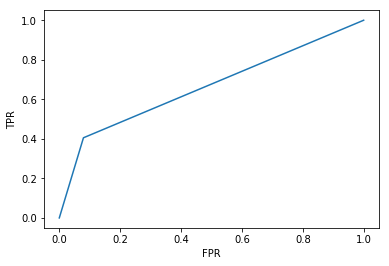

In [321]:
# roc auc knn
from sklearn.metrics import auc, roc_curve, roc_auc_score
y_test = news_class[300:400]
x_test = features[300:400]
fpr, tpr, _ = roc_curve(y_test, predictions_knn)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print (auc_val)

0.5692835692835694


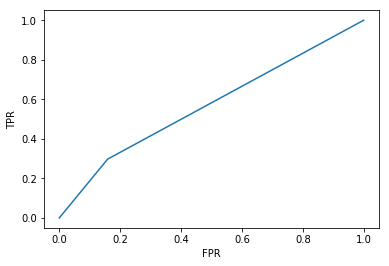

In [348]:
y_test = news_class[300:400]
x_test = features[300:400]
fpr, tpr, _ = roc_curve(y_test, predictions_clf)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print (auc_val)

0.6876876876876876


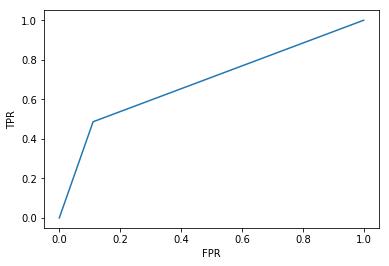

In [323]:
y_test = news_class[300:400]
x_test = features[300:400]
fpr, tpr, _ = roc_curve(y_test, predictions_bagknn)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print (auc_val)

0.5851565851565852


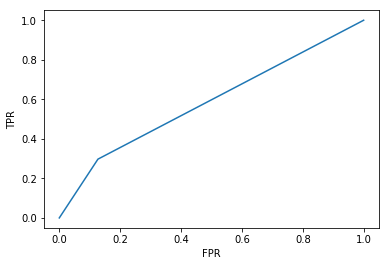

In [349]:
y_test = news_class[300:400]
x_test = features[300:400]
fpr, tpr, _ = roc_curve(y_test, predictions_bagclf)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print (auc_val)